In [ ]:
# Cell 1: Basic Setup & Path Configuration

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

# Mount drive in Colab only (with try/except to avoid errors on multiple runs)
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass

# Your project root path (as previously configured)
project_root = "/content/drive/MyDrive/Colab Notebooks/ecg-augmentation-repro-minkuek2"
data_dir = os.path.join(project_root, "data")
src_dir = os.path.join(project_root, "src")

print("Project root:", project_root)
print("Data dir:", data_dir)
print("Train file exists:", os.path.exists(os.path.join(data_dir, "mitbih_train.csv")))
print("Test file exists :", os.path.exists(os.path.join(data_dir, "mitbih_test.csv")))

# Add src folder to Python module path (to import dataset.py, model.py, augmentations.py, etc.)
import sys
if src_dir not in sys.path:
    sys.path.append(src_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project root: /content/drive/MyDrive/Colab Notebooks/ecg-augmentation-repro-minkuek2
Data dir: /content/drive/MyDrive/Colab Notebooks/ecg-augmentation-repro-minkuek2/data
Train file exists: True
Test file exists : True


In [16]:
from dataset import MITBIHArrhythmiaDataset, create_dataloaders
from augmentations import jitter, scaling, shift, permutation, magnitude_warp, time_warp

In [17]:
train_csv = os.path.join(data_dir, "mitbih_train.csv")
test_csv  = os.path.join(data_dir, "mitbih_test.csv")

train_df = pd.read_csv(train_csv, header=None)
test_df  = pd.read_csv(test_csv, header=None)

print("Train shape:", train_df.shape)   # (N_train, 188)
print("Test  shape:", test_df.shape)    # (N_test, 188)

train_df.head()

Train shape: (87554, 188)
Test  shape: (21892, 188)


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Train label value counts:
187
0.0    72471
1.0     2223
2.0     5788
3.0      641
4.0     6431
Name: count, dtype: int64

Test label value counts:
187
0.0    18118
1.0      556
2.0     1448
3.0      162
4.0     1608
Name: count, dtype: int64


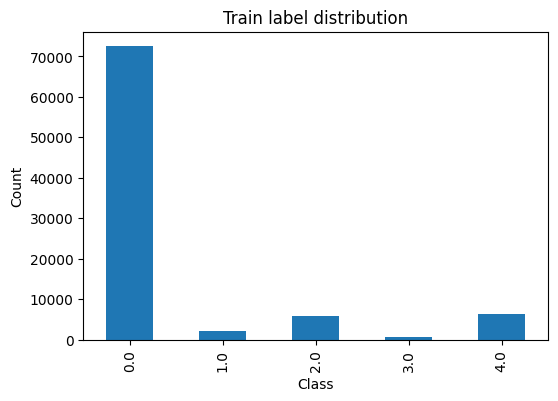

In [ ]:
# Last column is the label
train_labels = train_df.iloc[:, -1]
test_labels  = test_df.iloc[:, -1]

print("Train label value counts:")
print(train_labels.value_counts().sort_index())

print("\nTest label value counts:")
print(test_labels.value_counts().sort_index())

# Visualize with bar chart
plt.figure(figsize=(6,4))
train_labels.value_counts().sort_index().plot(kind="bar")
plt.title("Train label distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

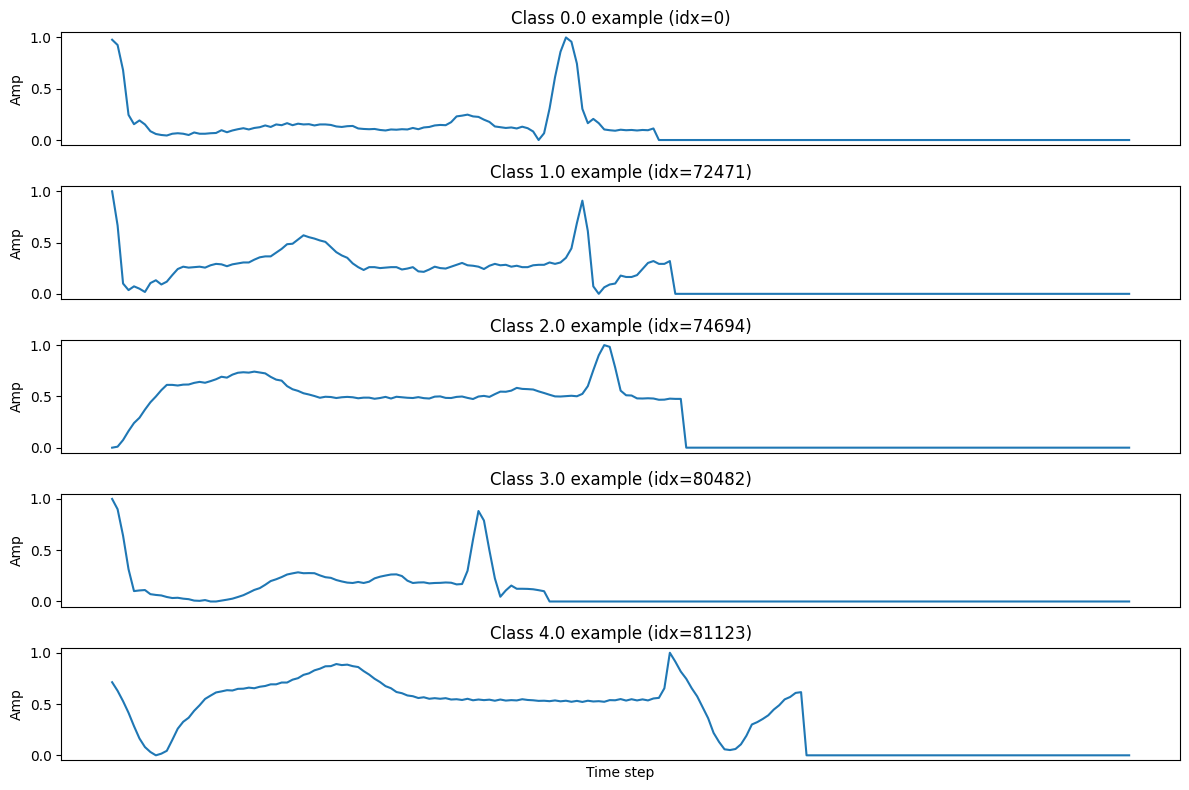

In [19]:
unique_labels = sorted(train_labels.unique())
plt.figure(figsize=(12, 8))

for i, cls in enumerate(unique_labels):
    # 해당 클래스의 첫 번째 인덱스
    sample_idx = train_labels[train_labels == cls].index[0]
    sig = train_df.iloc[sample_idx, :-1].values

    plt.subplot(len(unique_labels), 1, i+1)
    plt.plot(sig)
    plt.title(f"Class {cls} example (idx={sample_idx})")
    plt.xticks([])
    plt.ylabel("Amp")

plt.xlabel("Time step")
plt.tight_layout()
plt.show()

In [20]:
train_dataset = MITBIHArrhythmiaDataset(train_csv)
test_dataset  = MITBIHArrhythmiaDataset(test_csv)

print("len(train_dataset):", len(train_dataset))
print("len(test_dataset) :", len(test_dataset))

x0, y0 = train_dataset[0]
print("x0 shape (C, L):", x0.shape)  # (1, 187) 이어야 함
print("y0 label:", y0)

len(train_dataset): 87554
len(test_dataset) : 21892
x0 shape (C, L): torch.Size([1, 187])
y0 label: tensor(0)


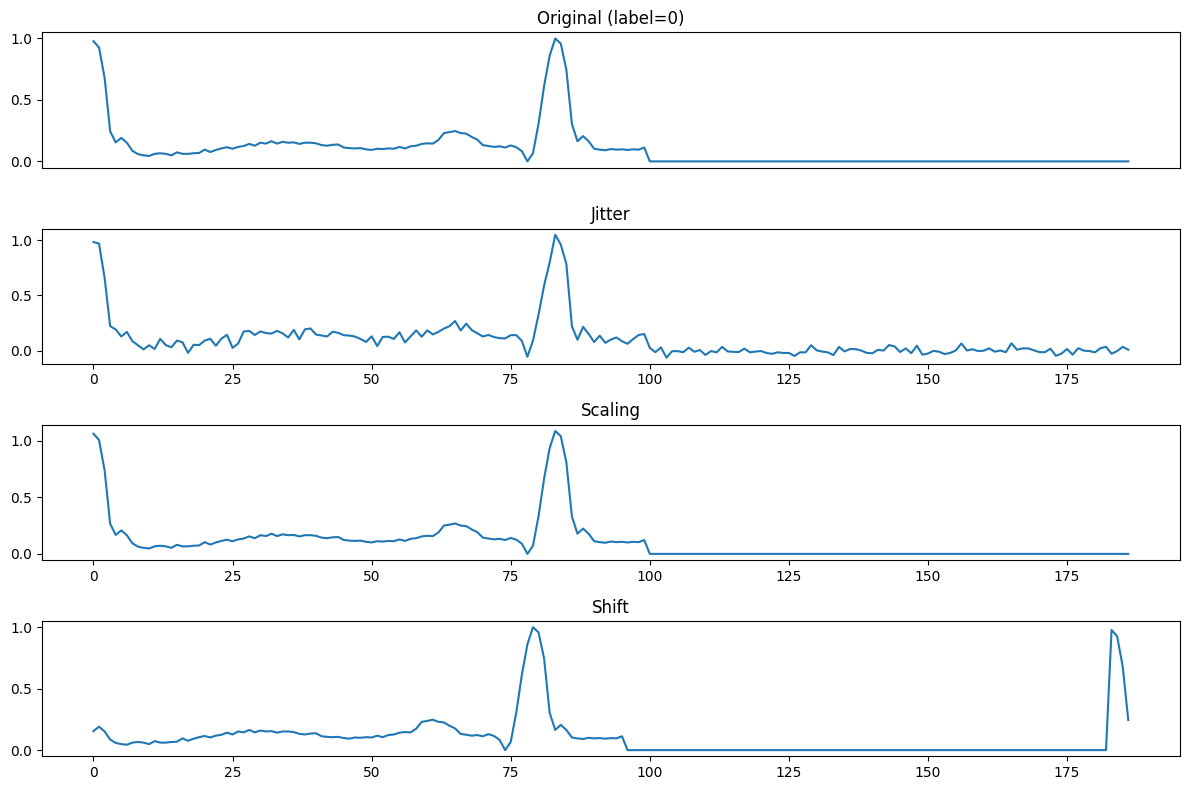

In [21]:
# 한 샘플 선택
idx = 0
signal = train_df.iloc[idx, :-1].values.astype(np.float32)
label  = int(train_df.iloc[idx, -1])

# 몇 가지 augmentation 적용
sig_jitter = jitter(signal.copy())
sig_scale  = scaling(signal.copy())
sig_shift  = shift(signal.copy())
sig_perm   = permutation(signal.copy())

plt.figure(figsize=(12, 8))

plt.subplot(4,1,1)
plt.plot(signal)
plt.title(f"Original (label={label})")
plt.xticks([])

plt.subplot(4,1,2)
plt.plot(sig_jitter)
plt.title("Jitter")

plt.subplot(4,1,3)
plt.plot(sig_scale)
plt.title("Scaling")

plt.subplot(4,1,4)
plt.plot(sig_shift)
plt.title("Shift")

plt.tight_layout()
plt.show()